In [108]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.9.19 (main, Apr  6 2024, 17:57:55) 
[GCC 9.4.0]
PCSE version: 5.5.6


In [109]:
import numpy as np
from pyesmda import ESMDA, ESMDA_RS

def forward_model(m_ensemble):
    param_names = [
        "TDWI", "WAV", "SPAN", "SMFCF"
    ]

    pred_list = []
    for i in range(m_ensemble.shape[0]):
        params = m_ensemble[i]
        p = copy.deepcopy(parameters)
        for j, param in enumerate(param_names):
            p.set_override(param, params[j])

        member = Wofost72_WLP_FD(p, weather, agromanagement)
        member.run_till_terminate()
        pred_df = pd.DataFrame(member.get_output())
        preds = pred_df["LAI"].values
        pred_list.append(preds)

    pred_arr = np.array(pred_list)
    return pred_arr

In [110]:
variables_for_DA = ["LAI", "SM"]
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value                                                                 
observed_sm = np.array([0.285, 0.26, 0.28, 0.18, 0.17])
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value
observations_for_DA = []
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai), "SM": (sm, errsm)}) for d, lai, errlai, sm, errsm in zip(dates_of_observation, observed_lai, std_lai, observed_sm, std_sm)]

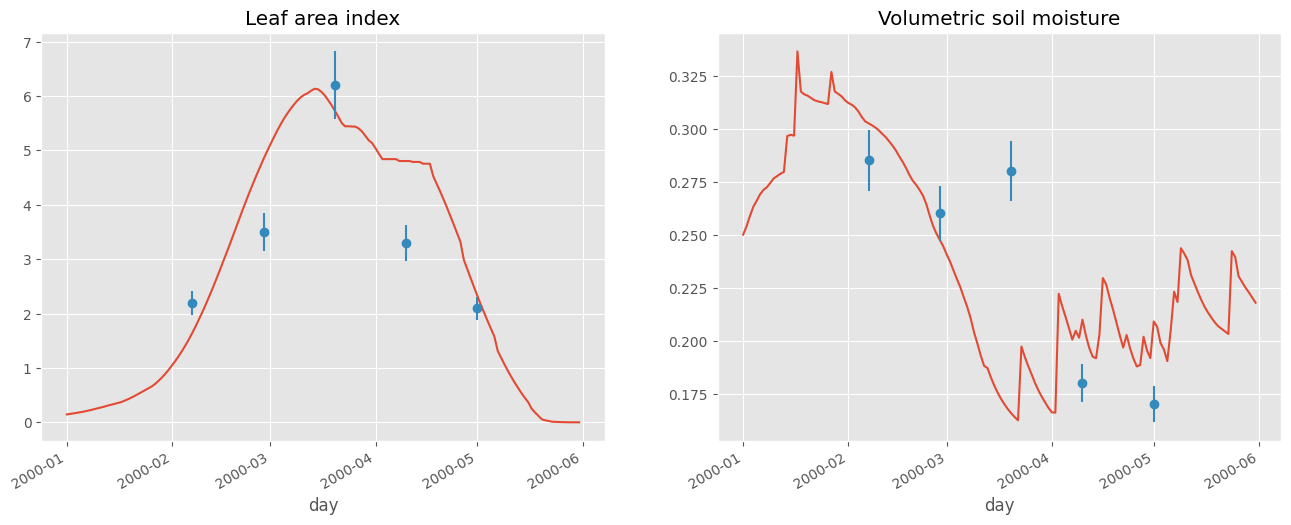

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
df["LAI"].plot(ax=axes[0], label="leaf area index")
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df["SM"].plot(ax=axes[1], label="rootzone soil moisture")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()

In [76]:
override_parameters = {}
override_parameters["TDWI"] = 160
override_parameters["WAV"] = 5
override_parameters["SPAN"] = 33
override_parameters["SMFCF"] = .33

p = copy.deepcopy(parameters)
for par, distr in override_parameters.items():
    p.set_override(par, distr)
ground_truth = Wofost72_WLP_FD(p, weather, agromanagement)
ground_truth.run_till_terminate()

output_df = pd.DataFrame(ground_truth.get_output())
obs = output_df["LAI"].values
output_df

,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
0,2000-01-01,0.000000,0.110240,80.000000,0.000000,52.000000,28.000000,80.000000,0.004429,10.0,0.250000,14.090000
1,2000-01-02,0.008867,0.117624,85.358251,0.000000,55.482863,29.875388,85.358251,0.002547,11.2,0.244819,14.053816
2,2000-01-03,0.017157,0.125290,90.921918,0.000000,59.099247,31.822671,90.921918,0.001995,12.4,0.242331,14.038579
3,2000-01-04,0.024293,0.133008,96.522179,0.000000,62.739416,33.782763,96.522179,0.004869,13.6,0.240616,14.027895
4,2000-01-05,0.032706,0.141716,102.841829,0.000000,66.847189,35.994640,102.841829,0.002797,14.8,0.238408,14.005806
...,...,...,...,...,...,...,...,...,...,...,...,...
147,2000-05-27,1.934169,0.003116,12332.320594,6649.452325,2486.526710,3196.341558,1267.657506,0.000822,60.0,0.240065,14.403914
148,2000-05-28,1.953874,0.003116,12332.320594,6649.452325,2486.526710,3196.341558,1267.657506,0.000826,60.0,0.237451,14.247070
149,2000-05-29,1.974056,0.000000,12332.320594,6649.452325,2486.526710,3196.341558,1267.657506,0.000000,60.0,0.235169,14.110155
150,2000-05-30,1.995758,0.000000,12332.320594,6649.452325,2486.526710,3196.341558,1267.657506,0.000000,60.0,0.232671,13.960288


In [80]:
n_ensemble = 50   
n_assimilations = 3
m_ensemble = np.array([
    np.random.normal(150., 50., (n_ensemble)),
    np.random.normal(4.5, 1.5, (n_ensemble)),
    np.random.normal(31, 3 ,(n_ensemble)),
    np.random.normal(0.31, 0.03 ,(n_ensemble))
]).T

cov_obs = np.eye(obs.shape[0]) 

std_m_prior = np.array([150, 4.5, 31, 0.31])

m_bounds = np.array([[0.0, 300], [0, 10], [10, 50], [0, 1]])

cov_obs_inflation_geo = 1.2
cov_obs_inflation_factors: list[float] = [1.1]
for l in range(1, n_assimilations):
    cov_obs_inflation_factors.append(
        cov_obs_inflation_factors[l - 1] / cov_obs_inflation_geo
)

In [81]:
solver = ESMDA(
    obs,
    m_ensemble,
    cov_obs,
    forward_model,
    n_assimilations=n_assimilations,
    cov_obs_inflation_factors=cov_obs_inflation_factors,
    m_bounds=m_bounds,
    save_ensembles_history=True,
    seed=100
)

solver.solve()

Assimilation # 1
Assimilation # 2
Assimilation # 3


In [82]:
np.average(solver.m_prior, axis=0)

array([164.30887478,   4.93977938,  33.01476056,   0.3162911 ])

In [83]:
np.sqrt(np.diagonal(solver.cov_mm))

array([10.81321319,  0.19992623,  0.478532  ,  0.02785187])

In [101]:
pred_dfs = [
    pd.DataFrame(preds)
    for preds in solver.d_pred
]

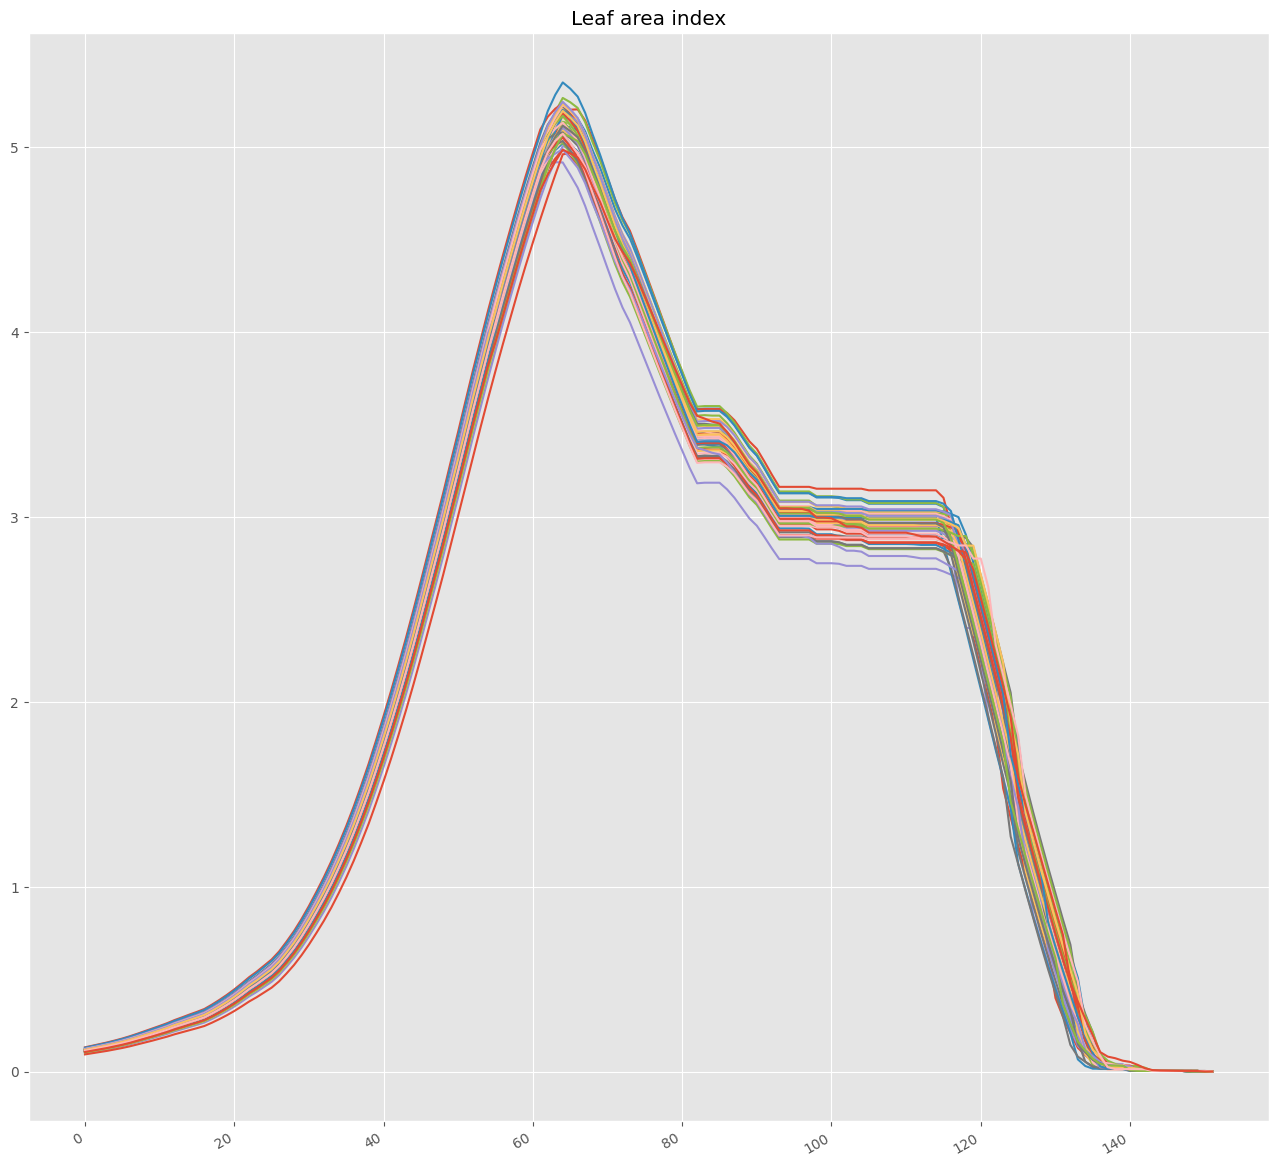

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,16), sharex=False)
for i, pred_df in enumerate(pred_dfs):
    pred_df[0].plot(ax=ax)
ax.set_title("Leaf area index")
fig.autofmt_xdate()